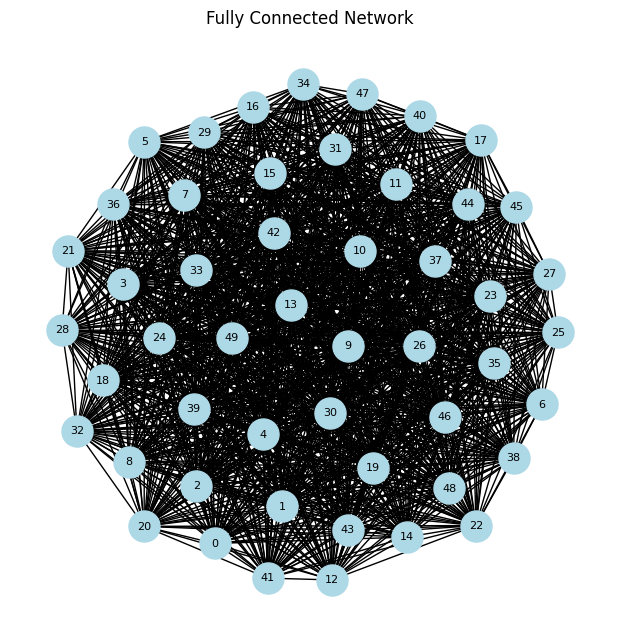

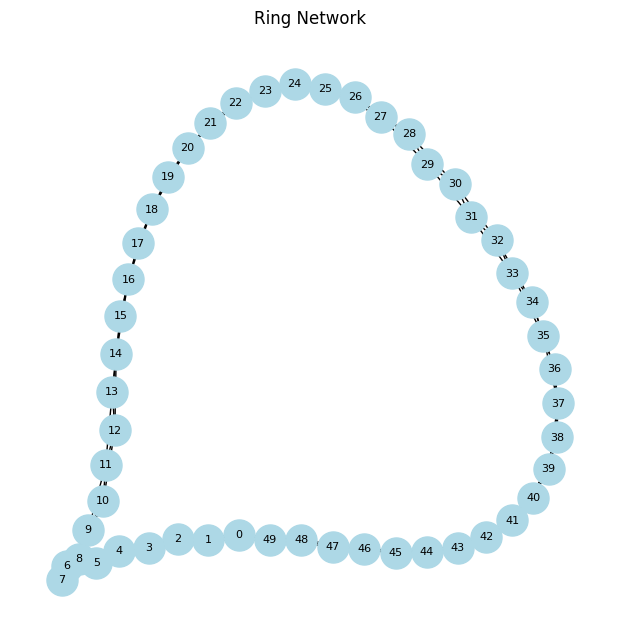

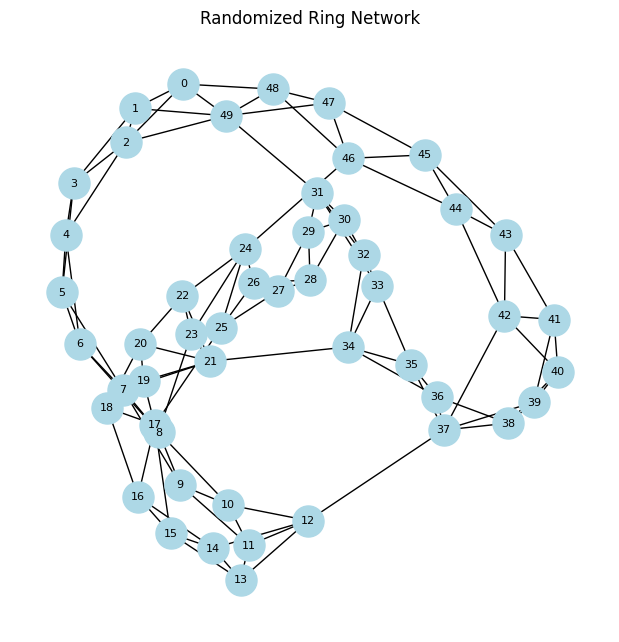

Running for Fully Connected...


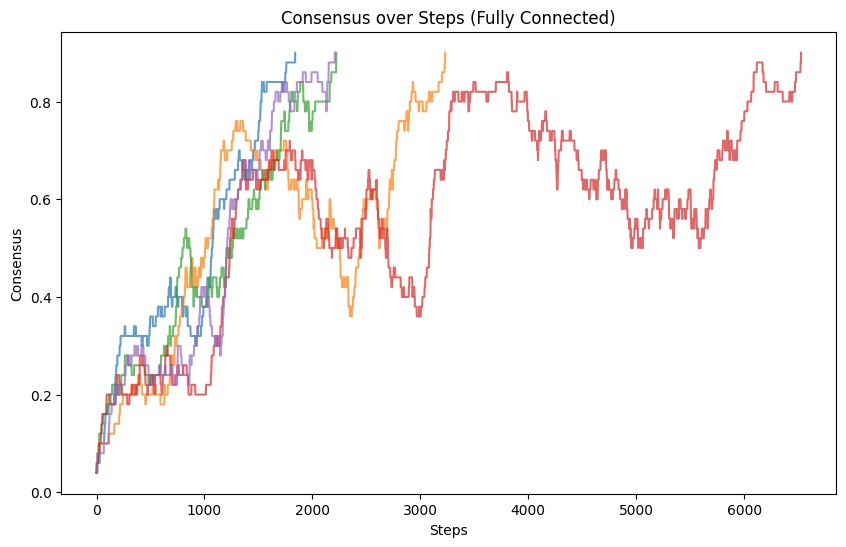

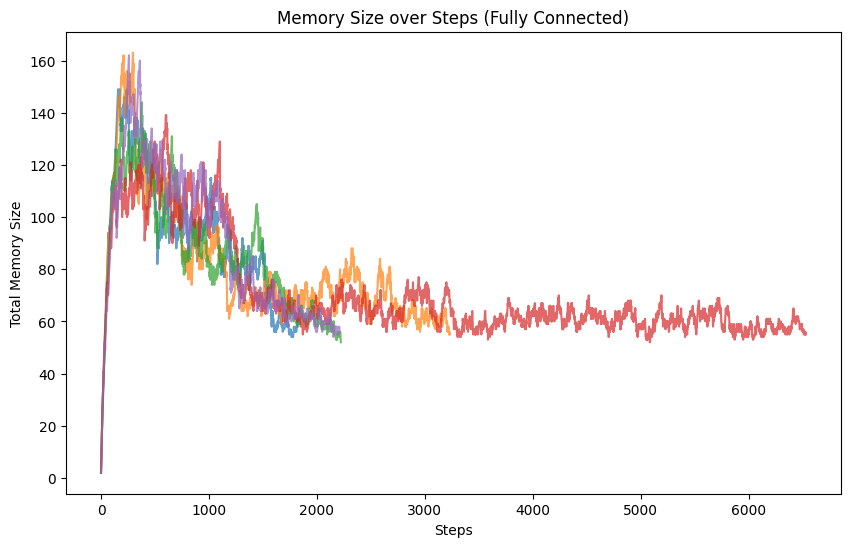

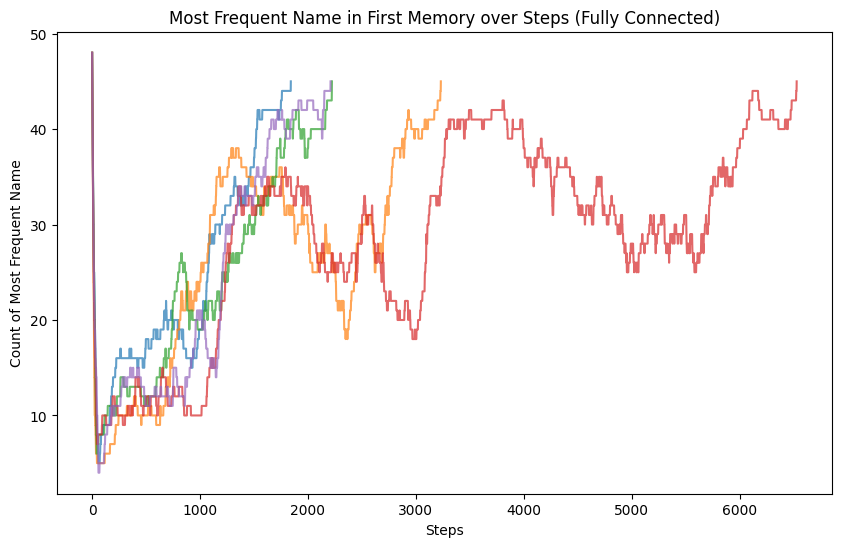

Running for Ring Network...


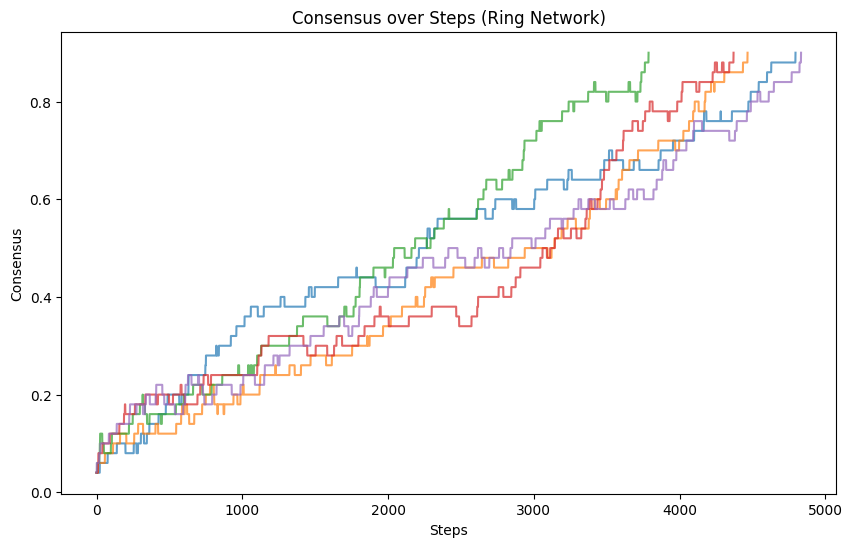

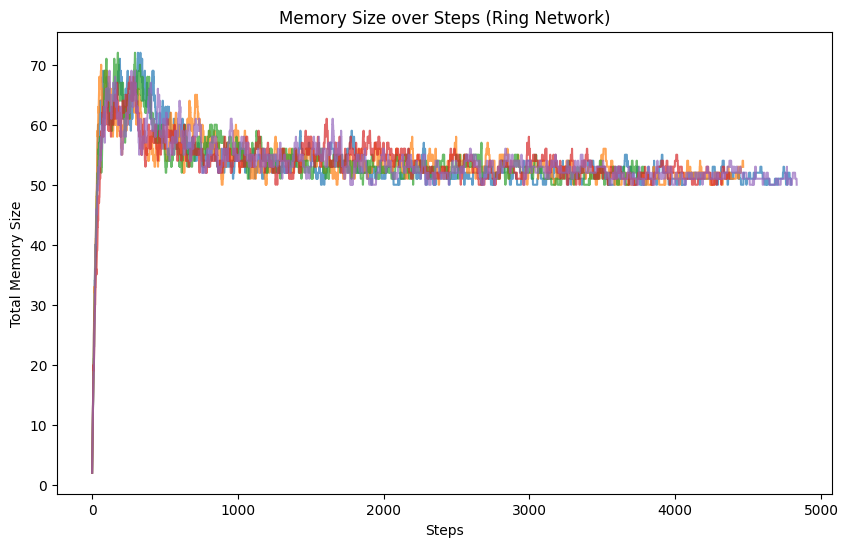

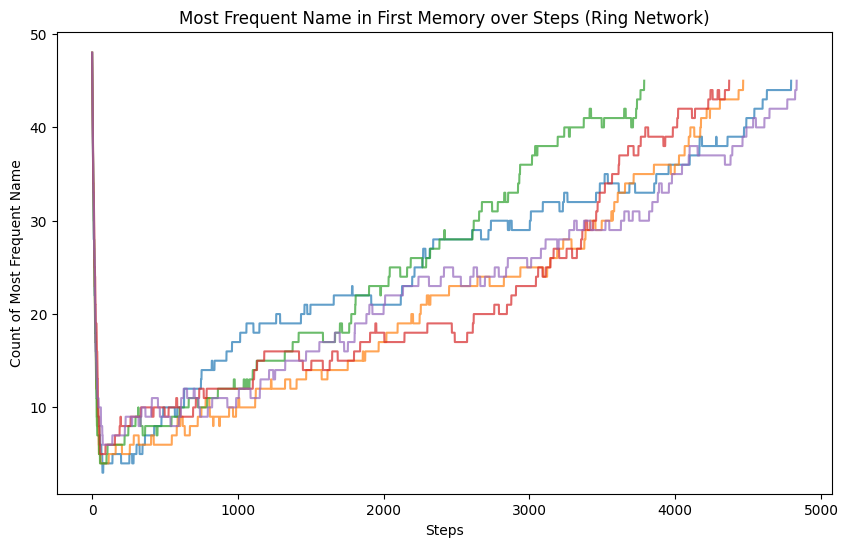

Running for Randomized Ring Network...


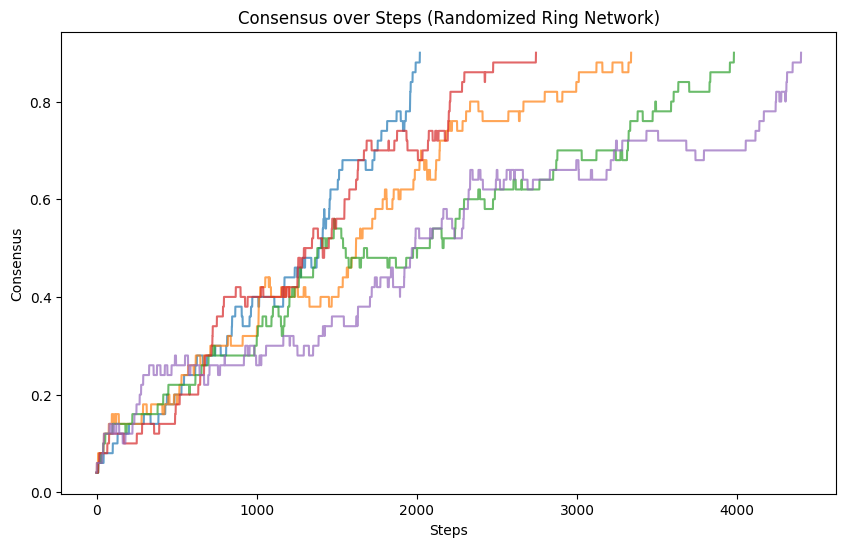

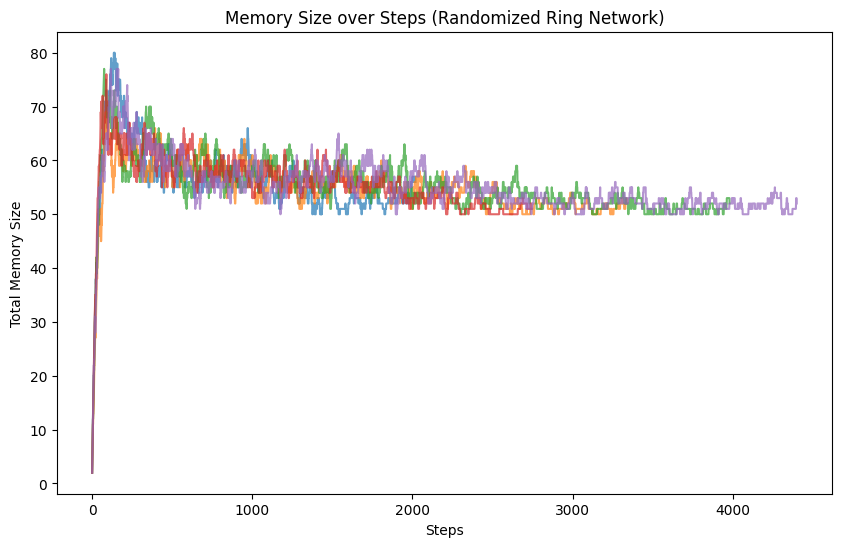

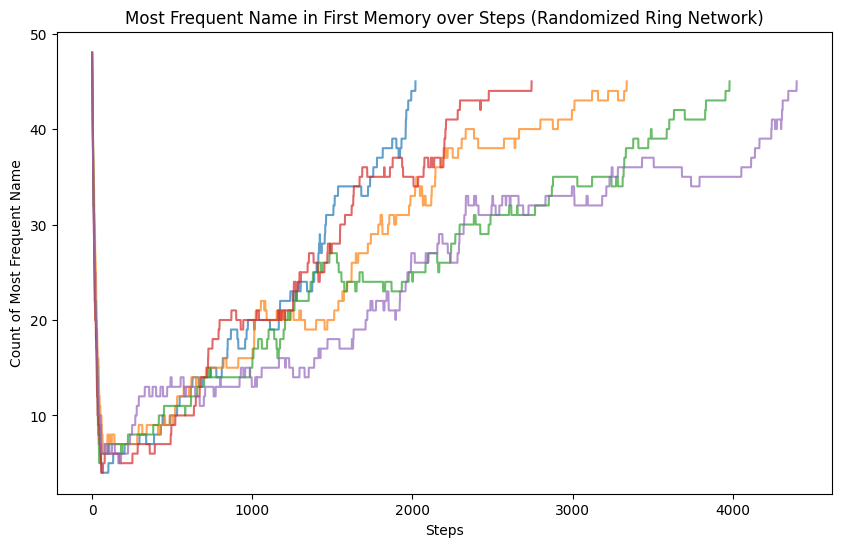

In [4]:
import networkx as nx  # NetworkX library for creating and manipulating networks
import random  # For random number generation
import matplotlib.pyplot as plt  # For plotting graphs
from collections import Counter  # For counting occurrences of names

# --- STEP 1: Network Creation Functions ---
def create_fully_connected_network(n):
    """
    Creates a fully connected network (complete graph) with 'n' nodes.
    Every node is connected to every other node in the network.
    """
    return nx.complete_graph(n)

def create_ring_network(n):
    """
    Creates a ring network with 'n' nodes. Each node is connected to its two immediate neighbors,
    forming a circular topology.
    """
    G = nx.Graph()  # Initialize an empty graph
    for i in range(n):
        for j in range(1, 3):  # Connect each node to its neighbors at distance 1 and 2
            G.add_edge(i, (i + j) % n)  # Connect node i to (i+j)%n
            G.add_edge(i, (i - j) % n)  # Connect node i to (i-j)%n (to form a ring)
    return G

def create_randomized_ring_network(n, extra_edges=10):
    """
    Creates a randomized ring network. It starts with a ring network and adds 'extra_edges' random
    edges to increase the network's connectivity.
    """
    G = create_ring_network(n)  # Start with a basic ring network
    nodes = list(G.nodes())  # List all nodes in the graph
    for _ in range(extra_edges):
        u, v = random.sample(nodes, 2)  # Randomly select two nodes u and v
        G.add_edge(u, v)  # Add a random edge between u and v
    return G

def plot_network(G, title):
    """
    Plots the given network using NetworkX and matplotlib.
    The graph layout is computed using a spring layout.
    """
    plt.figure(figsize=(6, 6))  # Set the figure size
    pos = nx.spring_layout(G, seed=42)  # Compute the layout for node positions
    nx.draw(G, pos, with_labels=True, node_size=500, node_color="lightblue", font_size=8)  # Draw the network
    plt.title(title)  # Title of the plot
    plt.show()  # Display the plot

# Create networks of 50 nodes
n = 50
fully_connected = create_fully_connected_network(n)
ring_network = create_ring_network(n)
randomized_ring = create_randomized_ring_network(n)

# Plot the generated networks
plot_network(fully_connected, "Fully Connected Network")
plot_network(ring_network, "Ring Network")
plot_network(randomized_ring, "Randomized Ring Network")

# --- STEP 2: Naming Game Simulation ---
def initialize_agents(n):
    """
    Initializes the agents. Each agent starts with an empty memory.
    The memory is a list of names.
    """
    return {i: [] for i in range(n)}  # Create a dictionary where keys are agent IDs and values are memory lists

def generate_new_name(used_names):
    """
    Generates a new unique name that hasn't been used before in the simulation.
    The name follows the format 'Name_X', where X is the number of names already used.
    """
    new_name = f"Name_{len(used_names)}"  # Create a new name based on how many names have been used
    used_names.add(new_name)  # Add the new name to the set of used names
    return new_name

def naming_game_step(agents, G, used_names):
    """
    Simulates one step of the naming game. In this step, a speaker and a hearer are randomly chosen
    from the graph and interact based on the naming game rules.
    """
    speaker, hearer = random.sample(list(G.edges()), 1)[0]  # Randomly select a pair of connected agents
    speaker_memory = agents[speaker]  # Get the speaker's memory
    hearer_memory = agents[hearer]  # Get the hearer's memory

    # If the speaker has no name, it generates a new name
    if not speaker_memory:
        name = generate_new_name(used_names)
        speaker_memory.append(name)
    else:
        name = speaker_memory[0]  # Use the first name in the speaker's memory

    # If the hearer already knows the name, both agents adopt this name exclusively
    if name in hearer_memory:
        agents[speaker] = [name]  # Both agents now have only this name in their memory
        agents[hearer] = [name]
    else:
        # If the hearer does not know the name, it adds the name to its memory (FIFO if overflows)
        hearer_memory.append(name)
        if len(hearer_memory) > 10:  # If the hearer's memory exceeds 10 names, remove the oldest
            hearer_memory.pop(0)

def calculate_consensus(agents):
    """
    Calculates the consensus level, defined as the fraction of agents using the most common name.
    """
    all_names = [name for memory in agents.values() for name in memory[:1]]  # Get the first name in each agent's memory
    if not all_names:
        return 0
    most_common_name, count = Counter(all_names).most_common(1)[0]  # Find the most common name
    return count / len(agents)  # Return the fraction of agents using this most common name

def most_frequent_name_in_first_memory(agents):
    """
    Returns the most frequent name in the first memory slot of all agents.
    """
    first_names = [memory[0] if memory else None for memory in agents.values()]  # Get the first name from each agent's memory
    most_common = Counter(first_names).most_common(1)  # Find the most common name
    if most_common:
        return most_common[0][0], most_common[0][1]  # Return the name and its frequency
    return None, 0  # If no names are found, return None

def simulate_naming_game(G, max_steps=10**6):
    """
    Runs the naming game simulation until consensus is reached (90%) or the maximum number of steps is reached.
    """
    agents = initialize_agents(len(G))  # Initialize the agents with empty memories
    used_names = set()  # Set of names that have been used in the simulation
    consensus = 0  # Initial consensus level
    step = 0  # Step counter

    # Lists to track the progress of consensus, memory size, and most frequent name
    consensus_steps = []
    memory_sizes = []
    most_frequent_name_steps = []

    while consensus < 0.9 and step < max_steps:  # Continue until consensus reaches 90% or steps exceed limit
        naming_game_step(agents, G, used_names)  # Perform one step of the naming game
        consensus = calculate_consensus(agents)  # Calculate the current consensus level
        total_memory_size = sum(len(memory) for memory in agents.values())  # Calculate total memory size

        # Track the most frequent name in the first memory slot
        most_frequent_name, count = most_frequent_name_in_first_memory(agents)
        most_frequent_name_steps.append((step, count))

        consensus_steps.append((step, consensus))  # Record consensus at this step
        memory_sizes.append((step, total_memory_size))  # Record memory usage at this step

        step += 1  # Increment the step counter

    return consensus_steps, memory_sizes, most_frequent_name_steps

# --- STEP 3: Plotting Results ---
def plot_results(results, title, ylabel):
    """
    Plots a graph for the given results (steps vs values), with the specified title and y-axis label.
    """
    plt.figure(figsize=(10, 6))  # Set up the plot size
    for res in results:
        steps, values = zip(*res)  # Unzip the results into steps and values
        plt.plot(steps, values, alpha=0.7)  # Plot the data with some transparency
    plt.title(title)  # Set the plot title
    plt.xlabel("Steps")  # Label for the x-axis
    plt.ylabel(ylabel)  # Label for the y-axis
    plt.show()  # Display the plot

def plot_overview(results, network_name):
    """
    Plots an overview of the simulation results, including consensus, memory size, and most frequent name.
    """
    consensus_results, memory_results, most_frequent_name_results = results
    # Plot each result
    plot_results(consensus_results, f"Consensus over Steps ({network_name})", "Consensus")
    plot_results(memory_results, f"Memory Size over Steps ({network_name})", "Total Memory Size")
    plot_results(most_frequent_name_results, f"Most Frequent Name in First Memory over Steps ({network_name})", "Count of Most Frequent Name")

def run_experiment():
    """
    Runs the experiment for multiple network types and plots the results.
    """
    networks = [
        ("Fully Connected", fully_connected),
        ("Ring Network", ring_network),
        ("Randomized Ring Network", randomized_ring),
    ]
    all_results = {}

    # Run the experiment for each network type and collect the results
    for name, network in networks:
        print(f"Running for {name}...")
        results_consensus = []
        results_memory = []
        results_most_frequent_name = []

        for _ in range(5):  # Run 5 simulations for each network to ensure reliability
            consensus_steps, memory_sizes, most_frequent_name_steps = simulate_naming_game(network)
            results_consensus.append(consensus_steps)
            results_memory.append(memory_sizes)
            results_most_frequent_name.append(most_frequent_name_steps)

        all_results[name] = (results_consensus, results_memory, results_most_frequent_name)  # Store results
        plot_overview((results_consensus, results_memory, results_most_frequent_name), name)  # Plot the results

    return all_results  # Return all experiment results

# Execute the experiment
experiment_results = run_experiment()